In [10]:
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.xception import decode_predictions

In [11]:
print("[INFO]: Trying to Read the images")
#  Configure the Image Location
# 이미지 위치 구성하기
imagePaths = list(paths.list_images(r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate'))

[INFO]: Trying to Read the images


In [12]:
imagePaths = list(paths.list_images("Dataset/rotate"))
len(imagePaths)
imagePaths[0].split(os.path.sep)[-3]

'dataset0'

In [4]:
len(imagePaths)

90

In [5]:
from datetime import datetime
datetime.now().strftime('%H:%M:%S')

'17:24:03'

In [6]:
# Initialize data and labels
# 데이터 및 레이블 초기화
data = []
labels = []
dirList= []

In [7]:
a = {}
a["1"] = "fcvasd"
a["2"] = 34


In [13]:
#imagePaths = r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate'
dirList = {}
for imagePath in imagePaths:
    print(imagePath)
    dataset = imagePath.split(os.path.sep)[-3]
    if dataset not in list(dirList.keys()):
        dirList[dataset] = []
    dirList[dataset].append(imagePath)

Dataset/rotate\dataset0\0\n13_1_00002_right.tif
Dataset/rotate\dataset0\0\n13_1_00003_left.tif
Dataset/rotate\dataset0\0\n13_2_00001_right.tif
Dataset/rotate\dataset0\0\n14_1_00001_right.tif
Dataset/rotate\dataset0\0\n14_1_00007_left.tif
Dataset/rotate\dataset0\0\n15_2_00005_left.tif
Dataset/rotate\dataset0\0\n1_1_00001_right.tif
Dataset/rotate\dataset0\0\n6_1_00004_right.tif
Dataset/rotate\dataset0\0\n6_1_00006_left.tif
Dataset/rotate\dataset0\1\14_1_00002_right.tif
Dataset/rotate\dataset0\1\7_1_00001_right.tif
Dataset/rotate\dataset0\1\7_1_00005_left.tif
Dataset/rotate\dataset0\2\2_1_00002_right.tif
Dataset/rotate\dataset0\2\2_1_00005_left.tif
Dataset/rotate\dataset0\2\3_1_00003_left.tif
Dataset/rotate\dataset0\2\4_1_00002_right.tif
Dataset/rotate\dataset0\2\6_1_00001_right.tif
Dataset/rotate\dataset0\2\6_1_00006_left.tif
Dataset/rotate\dataset1\0\n17_4_00006_left.tif
Dataset/rotate\dataset1\0\n17_5_00003_left.tif
Dataset/rotate\dataset1\0\n17_7_00013_left.tif
Dataset/rotate\dataset1

In [39]:
dirList = {}
for imagePath in imagePaths:
    dataset = imagePath.split(os.path.sep)[-3]
    if dataset not in list(dirList.keys()):
        dirList[dataset] = []
    dirList[dataset].append(imagePath)

    
dirListKeys = list(dirList.keys())
print(dirListKeys)
        
for data_i in range(0, len(dirListKeys)):
    testSetData = []
    trainSetData = []
    for data_j in range(0, len(dirListKeys)):
        if data_i == data_j:
            testSetData = testSetData + dirList[dirListKeys[data_j]]
        else:
            trainSetData = trainSetData + dirList[dirListKeys[data_j]]
    print("TestSet")
    print(len(testSetData))
    print("TrainSet")
    print(len(trainSetData))
testSetData

['dataset0', 'dataset1', 'dataset2', 'dataset3', 'dataset4']
TestSet
18
TrainSet
72
TestSet
19
TrainSet
71
TestSet
18
TrainSet
72
TestSet
18
TrainSet
72
TestSet
17
TrainSet
73


['Dataset/rotate\\dataset4\\0\\n34_2_00001_right.tif',
 'Dataset/rotate\\dataset4\\0\\n35_1_00009_left.tif',
 'Dataset/rotate\\dataset4\\0\\n35_1_00010_left.tif',
 'Dataset/rotate\\dataset4\\0\\n35_1_00011_right.tif',
 'Dataset/rotate\\dataset4\\0\\n35_1_00012_right.tif',
 'Dataset/rotate\\dataset4\\0\\n35_2_00001_right.tif',
 'Dataset/rotate\\dataset4\\0\\n35_2_00002_right.tif',
 'Dataset/rotate\\dataset4\\0\\n35_2_00007_left.tif',
 'Dataset/rotate\\dataset4\\1\\30_1_00011_right.tif',
 'Dataset/rotate\\dataset4\\1\\30_1_00013_left.tif',
 'Dataset/rotate\\dataset4\\1\\34_1_00002_right.tif',
 'Dataset/rotate\\dataset4\\2\\22_1_00005_left.tif',
 'Dataset/rotate\\dataset4\\2\\27_1_00005_left.tif',
 'Dataset/rotate\\dataset4\\2\\35_1_00002_right.tif',
 'Dataset/rotate\\dataset4\\2\\35_2_00003_left.tif',
 'Dataset/rotate\\dataset4\\2\\35_3_00001_right.tif',
 'Dataset/rotate\\dataset4\\2\\35_3_00004_left.tif']

In [17]:
dirList = []
for imagePath in imagePaths:
    dataDir = imagePath.split(os.path.sep)[-3]
    if dataDir in dirList:
        continue
    dirList.append(dataDir)
dirList

['dataset0', 'dataset1', 'dataset2', 'dataset3', 'dataset4']

In [6]:
# Formatting data and labels
for imagePath in imagePaths:
    # Extract the class label from file name and append to labels
    # 파일 이름에서 클래스 레이블을 추출하고 레이블에 추가함
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    # Load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring the aspect ratio
    # 이미지를 로드하고, 컬러 채널을 스왑하고, 가로 세로 비율을 무시하고 고정 224x224 픽셀로 크기를 조정함
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Append to data
    # 데이터에 추가
    data.append(image)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0,1]
# 픽셀 강도를 [0,1] 범위로 조정하면서 데이터와 레이블을 NumPy 배열로 변환
data = np.array(data) / 255.0
labels = np.array(labels)

In [7]:
labels.shape

(90,)

In [8]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2',
       '2', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2', '2', '2',
       '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '1', '2', '2', '2', '2', '2', '2'],
      dtype='<U1')

In [9]:
data.shape

(90, 224, 224, 3)

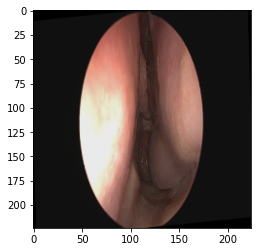

In [10]:
plt.imshow(data[1])

In [11]:
# Perform the one-hot encoding on the labels
# 레이블에 대해 원핫 인코딩 수행
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [12]:
# Initialize the training data augmentation
# 교육 데이터 억멘테이션 초기화
trainAug = ImageDataGenerator(rotation_range=40, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
		shear_range=0.15,fill_mode="nearest", horizontal_flip=True)

In [13]:
labels.shape

(90, 3)

In [14]:
# Partition the data into training and testing splits using 80% of the training data and the remaining 20% for testing
# 교육 데이터의 80%, 테스트에 20%를 사용하여 데이터를 교육 및 테스트 분할로 분할
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [15]:
# Load the network, ensuring the Head-FC layer sets are left off
# Head-FC 레이어 세트가 포함되지 않도록 네트워크를 로드한다
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [16]:
# Construct the head model that will be placed on the top of the base model
# 보디 모델의 맨 위에 배치할 헤드 모델 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [17]:
# Place the Head-FC model on top of the Base model - This become the actual model that we will train
# Head-FC 모델을 보디 모델 위에 배치한다. 이것이 우리가 교육할 실제 모델이 될 것이다.
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
# Make sure that the basemodel layers will not be trained and only head model will be trained.
# 보디 모델 레이어가 훈련되지 않고 헤드 모델만 훈련되는지 확인한다.
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
trainX.shape

(72, 224, 224, 3)

In [20]:
testX.shape

(18, 224, 224, 3)

In [21]:
# Set the hyper-parameters
# 하이퍼 파라미터 설정
# INIT_LR = 1e-3
INIT_LR = 0.001
EPOCHS = 200
BS = 8

In [22]:
# Compile the Model
# 모델 컴파일
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [23]:
# Train the Network Model
# 모델 교육
print("[INFO] Model Training")
start = timeit.default_timer()
H = model.fit(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

[INFO] Model Training
Epoch 1/200
9/9 [==============================] - 8s 388ms/step - loss: 0.7286 - accuracy: 0.3194 - val_loss: 0.6088 - val_accuracy: 0.5000
Epoch 2/200
9/9 [==============================] - 1s 91ms/step - loss: 0.6178 - accuracy: 0.5417 - val_loss: 0.5839 - val_accuracy: 0.5000
Epoch 3/200
9/9 [==============================] - 1s 92ms/step - loss: 0.5931 - accuracy: 0.5139 - val_loss: 0.5883 - val_accuracy: 0.3333
Epoch 4/200
9/9 [==============================] - 1s 91ms/step - loss: 0.5757 - accuracy: 0.5417 - val_loss: 0.5752 - val_accuracy: 0.5556
Epoch 5/200
9/9 [==============================] - 1s 93ms/step - loss: 0.5522 - accuracy: 0.5694 - val_loss: 0.5745 - val_accuracy: 0.4444
Epoch 6/200
9/9 [==============================] - 1s 93ms/step - loss: 0.5530 - accuracy: 0.6528 - val_loss: 0.5583 - val_accuracy: 0.4444
Epoch 7/200
9/9 [==============================] - 1s 101ms/step - loss: 0.5085 - accuracy: 0.6389 - val_loss: 0.5545 - val_accuracy: 0.6

Epoch 59/200
9/9 [==============================] - 1s 96ms/step - loss: 0.3849 - accuracy: 0.7778 - val_loss: 0.4975 - val_accuracy: 0.6667
Epoch 60/200
9/9 [==============================] - 1s 91ms/step - loss: 0.3099 - accuracy: 0.8472 - val_loss: 0.5144 - val_accuracy: 0.6667
Epoch 61/200
9/9 [==============================] - 1s 92ms/step - loss: 0.3766 - accuracy: 0.7639 - val_loss: 0.4851 - val_accuracy: 0.6667
Epoch 62/200
9/9 [==============================] - 1s 96ms/step - loss: 0.2879 - accuracy: 0.8056 - val_loss: 0.4996 - val_accuracy: 0.6667
Epoch 63/200
9/9 [==============================] - 1s 95ms/step - loss: 0.3551 - accuracy: 0.7222 - val_loss: 0.6040 - val_accuracy: 0.6111
Epoch 64/200
9/9 [==============================] - 1s 98ms/step - loss: 0.3656 - accuracy: 0.7361 - val_loss: 0.6646 - val_accuracy: 0.6111
Epoch 65/200
9/9 [==============================] - 1s 96ms/step - loss: 0.4139 - accuracy: 0.7083 - val_loss: 0.5681 - val_accuracy: 0.6667
Epoch 66/200


Epoch 117/200
9/9 [==============================] - 1s 91ms/step - loss: 0.2685 - accuracy: 0.8889 - val_loss: 0.6103 - val_accuracy: 0.5556
Epoch 118/200
9/9 [==============================] - 1s 95ms/step - loss: 0.3149 - accuracy: 0.7778 - val_loss: 0.6231 - val_accuracy: 0.6667
Epoch 119/200
9/9 [==============================] - 1s 96ms/step - loss: 0.3112 - accuracy: 0.8194 - val_loss: 0.5749 - val_accuracy: 0.5556
Epoch 120/200
9/9 [==============================] - 1s 100ms/step - loss: 0.3348 - accuracy: 0.7639 - val_loss: 0.6123 - val_accuracy: 0.7222
Epoch 121/200
9/9 [==============================] - 1s 95ms/step - loss: 0.3001 - accuracy: 0.8194 - val_loss: 0.5920 - val_accuracy: 0.6111
Epoch 122/200
9/9 [==============================] - 1s 93ms/step - loss: 0.2844 - accuracy: 0.8472 - val_loss: 0.6149 - val_accuracy: 0.6111
Epoch 123/200
9/9 [==============================] - 1s 94ms/step - loss: 0.3008 - accuracy: 0.7778 - val_loss: 0.6326 - val_accuracy: 0.6667
Epoch

Epoch 175/200
9/9 [==============================] - 1s 93ms/step - loss: 0.2475 - accuracy: 0.8056 - val_loss: 0.8848 - val_accuracy: 0.6667
Epoch 176/200
9/9 [==============================] - 1s 93ms/step - loss: 0.3126 - accuracy: 0.7778 - val_loss: 0.8146 - val_accuracy: 0.6667
Epoch 177/200
9/9 [==============================] - 1s 96ms/step - loss: 0.2608 - accuracy: 0.7917 - val_loss: 0.8598 - val_accuracy: 0.6667
Epoch 178/200
9/9 [==============================] - 1s 93ms/step - loss: 0.2020 - accuracy: 0.8611 - val_loss: 0.9415 - val_accuracy: 0.6667
Epoch 179/200
9/9 [==============================] - 1s 92ms/step - loss: 0.2882 - accuracy: 0.8056 - val_loss: 0.8616 - val_accuracy: 0.6667
Epoch 180/200
9/9 [==============================] - 1s 93ms/step - loss: 0.2508 - accuracy: 0.8611 - val_loss: 0.7306 - val_accuracy: 0.6111
Epoch 181/200
9/9 [==============================] - 1s 93ms/step - loss: 0.1926 - accuracy: 0.9167 - val_loss: 0.7937 - val_accuracy: 0.6111
Epoch 

In [24]:
stop = timeit.default_timer()
print('Total Training Time: ', stop - start) 

Total Training Time:  189.0628587


In [25]:
testX.shape

(18, 224, 224, 3)

In [26]:
# Make predictions on the testing set
# 테스트 세트에서 예측한다
print("Making Predictions on the Test Set")
predIdxs = model.predict(testX, batch_size=BS)
preds = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)
print("Classification Report")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

Making Predictions on the Test Set
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.50      0.33      0.40         3
           2       0.50      0.33      0.40         6

    accuracy                           0.56        18
   macro avg       0.53      0.48      0.49        18
weighted avg       0.54      0.56      0.53        18



In [27]:
preds

array([[5.80181241e-01, 1.65758654e-03, 4.18161184e-01],
       [6.49632141e-03, 3.04181740e-04, 9.93199527e-01],
       [5.39274588e-02, 1.08428178e-02, 9.35229659e-01],
       [8.55322957e-01, 3.92716751e-03, 1.40749902e-01],
       [2.38317717e-02, 9.70240951e-01, 5.92735549e-03],
       [9.99851584e-01, 8.46042167e-06, 1.39896903e-04],
       [7.14303315e-01, 5.46479505e-03, 2.80231893e-01],
       [9.55554962e-01, 4.37505059e-02, 6.94501447e-04],
       [9.99984503e-01, 4.71583604e-07, 1.50114920e-05],
       [9.99994397e-01, 6.81580481e-09, 5.57365911e-06],
       [8.41323972e-01, 1.56681255e-01, 1.99483195e-03],
       [9.98669505e-01, 2.56528438e-05, 1.30486966e-03],
       [9.99998689e-01, 2.36776501e-08, 1.26521525e-06],
       [8.81621465e-02, 2.64287719e-05, 9.11811471e-01],
       [1.04854636e-01, 5.59428036e-01, 3.35717380e-01],
       [9.72307682e-01, 5.27403317e-05, 2.76395194e-02],
       [3.70898455e-01, 1.13548756e-01, 5.15552819e-01],
       [9.89999831e-01, 1.71811

In [28]:
len(predIdxs)

18

In [29]:
# Compute Confusion Matrix and derrive raw, accuracy, sensitivity, specificity from it
# 혼란 매트릭스
cm= confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1] + cm[2,2]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# 혼란 매트릭스 보기
print("Confusion Matrix and its Derrivatives")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Confusion Matrix and its Derrivatives
[[7 0 2]
 [2 1 0]
 [3 1 2]]
acc: 0.5556
sensitivity: 1.0000
specificity: 0.3333


In [30]:
H.history["accuracy"]

[0.3194444477558136,
 0.5416666865348816,
 0.5138888955116272,
 0.5416666865348816,
 0.5694444179534912,
 0.6527777910232544,
 0.6388888955116272,
 0.5555555820465088,
 0.5972222089767456,
 0.5972222089767456,
 0.6388888955116272,
 0.6666666865348816,
 0.625,
 0.625,
 0.5833333134651184,
 0.6388888955116272,
 0.7083333134651184,
 0.7083333134651184,
 0.6944444179534912,
 0.7083333134651184,
 0.625,
 0.6527777910232544,
 0.6805555820465088,
 0.6666666865348816,
 0.6388888955116272,
 0.6944444179534912,
 0.6805555820465088,
 0.7083333134651184,
 0.7222222089767456,
 0.7222222089767456,
 0.7361111044883728,
 0.6944444179534912,
 0.7361111044883728,
 0.7222222089767456,
 0.7083333134651184,
 0.6805555820465088,
 0.7083333134651184,
 0.8055555820465088,
 0.7361111044883728,
 0.7638888955116272,
 0.75,
 0.7222222089767456,
 0.75,
 0.7361111044883728,
 0.7222222089767456,
 0.8055555820465088,
 0.75,
 0.6944444179534912,
 0.7777777910232544,
 0.7916666865348816,
 0.7777777910232544,
 0.7638888

Final Plot Generated.


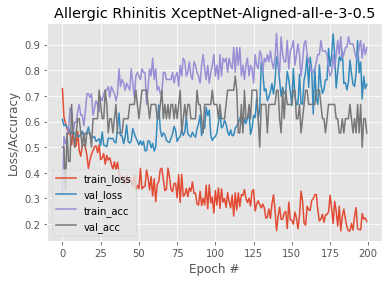

In [31]:
# plot the training loss and accuracy
# 플롯 그래프
print("Final Plot Generated.")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Allergic Rhinitis XceptNet-Aligned-all-e-3-0.5")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("[iter-3] [XCEPTN] plot,rotate-1e3")

model.output_shape # model summary representation
model.summary() # model configuration
model.get_config() # list all weight tensors in the model

In [32]:
model.output_shape

(None, 3)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [34]:
preds

array([[5.80181241e-01, 1.65758654e-03, 4.18161184e-01],
       [6.49632141e-03, 3.04181740e-04, 9.93199527e-01],
       [5.39274588e-02, 1.08428178e-02, 9.35229659e-01],
       [8.55322957e-01, 3.92716751e-03, 1.40749902e-01],
       [2.38317717e-02, 9.70240951e-01, 5.92735549e-03],
       [9.99851584e-01, 8.46042167e-06, 1.39896903e-04],
       [7.14303315e-01, 5.46479505e-03, 2.80231893e-01],
       [9.55554962e-01, 4.37505059e-02, 6.94501447e-04],
       [9.99984503e-01, 4.71583604e-07, 1.50114920e-05],
       [9.99994397e-01, 6.81580481e-09, 5.57365911e-06],
       [8.41323972e-01, 1.56681255e-01, 1.99483195e-03],
       [9.98669505e-01, 2.56528438e-05, 1.30486966e-03],
       [9.99998689e-01, 2.36776501e-08, 1.26521525e-06],
       [8.81621465e-02, 2.64287719e-05, 9.11811471e-01],
       [1.04854636e-01, 5.59428036e-01, 3.35717380e-01],
       [9.72307682e-01, 5.27403317e-05, 2.76395194e-02],
       [3.70898455e-01, 1.13548756e-01, 5.15552819e-01],
       [9.89999831e-01, 1.71811

In [35]:
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

C:\Users\cvpr\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


print("[INFO] saving Allergic Rhinitis detector model...")
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

decoded = imagenet_utils.decode_predictions(preds)

gradCAM


In [36]:
from gradCam import GradCAM
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [37]:
d_path = r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate\dataset0\1\7_1_00005_left.tif'
orig = cv2.imread(d_path)
resized = cv2.resize(orig, (224, 224))
image = load_img(d_path, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

cam = GradCAM(model, predIdxs)

In [38]:
preds = model.predict(image)
i = np.argmax(preds[0])
print(image.shape)

(1, 224, 224, 3)


In [39]:
cam = GradCAM(model, i)

In [40]:
heatmap = cam.compute_heatmap(image)

In [41]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

In [42]:
cv2.imshow("Output", heatmap)
cv2.imwrite("heatr", heatmap)

error: OpenCV(4.5.1) ..\modules\imgcodecs\src\loadsave.cpp:682: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [ ]:

(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [ ]:
for i in testX:
    image = np.expand_dims(i, axis=0)
    image = imagenet_utils.preprocess_input(i)
    heatmap = cam.compute_heatmap(image)